# XGBoost Regression Analysis of Wind Turbine Data

1. [Imports.](#Cell1)
1. [Load preprocessed training data set and split it into training and testing subsets.](#Cell2)
1. [Find out what default hyperparameters XGBoost suggests for this problem.](#Cell3)
1. [Set default hyperparameter values, then monitor model performance (rmse) as trees are added.](#Cell4)
1. [Tune the number and size of trees using cross-validation.](#Cell5)
1. [Tune the learning rate and the number of trees using cross-validation.](#Cell6)
1. [Tune the row subsampling.](#Cell7)
1. [Tune the column subsampling by split.](#Cell8)
1. [Tune the column subsampling by tree.](#Cell9)
1. [Tune the alpha regularization parameter.](#Cell10)
1. [Tune the lambda regularization parameter.](#Cell11)
1. [Tune gamma, the minimum loss reduction required to make a further partition on a leaf node of a tree.](#Cell11a)
1. [Tune min_child_weight, the minimum sum of instance weight (hessian) needed in a child](#Cell11b)
1. [Create separate models for each of the ten turbines, using cross-validation.](#Cell12)
1. [Retrieve from disk the regressor model that was trained on the training subsample only.](#Cell13)
1. [Test the fitted models on the testing subset.](#Cell14)
1. [Make histograms of the response variable in the training and testing subsets of the training data set.](#Cell14b)
1. [Plot predicted and actual turbine output as a function of time, from test set](#Cell14c)
1. [Plot feature importances averaged over all turbines.](#Cell15)
1. [Refit model with final settings to entire training data set and save fitted model to disk.](#Cell16)
1. [Retrieve trained model from disk. Only run this cell if previous one wasn't run.](#Cell17)
1. [Prepare the test data set in the same way as the training set, make predictions, and create output csv file.](#Cell18)
1. [Compute weekly RMSE, save to file and make a plot.](#Cell19)

<a id='Cell1'></a>

In [1]:
'''
Imports.
'''
import sys
import numpy as np
import scipy as sp
import scipy.stats as st
import pandas as pd
import sklearn
from   sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from   sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from   sklearn.externals import joblib
import xgboost as xgb
from   xgboost.sklearn import XGBRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
from   time import strftime
import datetime
from   operator import itemgetter
import csv

%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

print("Python version:           {0}".format(sys.version))
print("Scipy version:            {0}".format(sp.__version__))
print("Numpy version:            {0}".format(np.__version__))
print("Pandas version:           {0}".format(pd.__version__))
print("Sklearn version:          {0}".format(sklearn.__version__))
print("XGBoost version:          {0}".format(xgb.__version__))
print("Matplotlib version:       {0}".format(mpl.__version__))
jupyterVersion = ! jupyter notebook --version
print("Jupyter notebook version: {0}".format(jupyterVersion[0]))

Python version:           2.7.10 (v2.7.10:15c95b7d81dc, May 23 2015, 09:33:12) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
Scipy version:            0.19.0
Numpy version:            1.13.0
Pandas version:           0.18.1
Sklearn version:          0.18.1
XGBoost version:          0.6
Matplotlib version:       1.5.1
Jupyter notebook version: 5.0.0


<a id='Cell2'></a>

In [2]:
'''
Load preprocessed training data set and split it into training and testing subsets.
'''
# Set input parameters
N_train           = 10000  # Size of training subset within training data set
rmws              = 3      # Rolling mean window size
nturbines         = 10     # Number of different turbines in data set
wind_measurements = [1, 2, 3, 4, 6, 7, 9, 10]
gamlss            = False  # Flag to enable analysis on the same predictors as the gamlss analysis

# Select appropriate training data file
if rmws<=1:
    rm = "_"
    TrainingDataFile = "data/Train_pp_2017_02_27_18_37_05.pkl" # No rolling means
elif rmws==2:
    rm = "_rm2_"
    TrainingDataFile = "data/Train_pp_2017_03_11_22_52_56.pkl" # Rolling means over 2 measurements
elif rmws==3:
    rm = "_rm3_"
#    TrainingDataFile = "data/Train_pp_2017_03_09_17_07_30.pkl" # With rolling means over 3 measurements
#    TrainingDataFile = "data/Train_pp_2017_03_10_15_37_41.pkl" # Rolling means over 3 measurements
#    TrainingDataFile = "data/Train_pp_2017_03_27_17_43_43.pkl" # Rolling means over 3 measurements, dups removed
#    TrainingDataFile = "data/Train_pp_2017_10_22_17_15_21.pkl" # Rolling means over 3 measurements, dups removed
    TrainingDataFile = "data/Train_pp_2018_10_21_12_22_36.csv" # Rolling means over 3 measurements (excl.), dups removed
elif rmws==4:
    rm = "_rm4_"
    TrainingDataFile = "data/Train_pp_2017_03_11_02_06_50.pkl" # Rolling means over 4 measurements
else:
    print("Invalid rolling mean window size: {0}".format(rmws))
    
# Load data
if TrainingDataFile[-3:] == "pkl":
    df0 = pd.read_pickle(TrainingDataFile)
else:
    df0 = pd.read_csv(TrainingDataFile, header=[0,1])
print('Shape of loaded data frame: {0}'.format(df0.shape))

# Rename dataframe columns and make lists with the new predictor and target labels
predictors  = [item[0]+'_'+str(item[1]) if item[1].isdigit() else item[0] \
               for item in df0.columns.values if item[0]!='TARGETVAR']
targets     = [item[0]+'_'+str(item[1]) for item in df0.columns.values if item[0]=='TARGETVAR']
df0.columns = targets+predictors

# If desired, transform predictor variables to be the same as in the gamlss analysis
if gamlss:
    U10label  = ["U10"+rm+str(i) for i in wind_measurements]
    U100label = ["U100"+rm+str(i) for i in wind_measurements]
    V10label  = ["V10"+rm+str(i) for i in wind_measurements]
    V100label = ["V100"+rm+str(i) for i in wind_measurements]
    H10label  = ["H10"+rm+str(i) for i in wind_measurements]
    H100label = ["H100"+rm+str(i) for i in wind_measurements]
    for i in range(0,len(wind_measurements)):
        df0[H10label[i]]  = np.sqrt(df0[U10label[i]]**2 + df0[V10label[i]]**2)
        df0[H100label[i]] = np.sqrt(df0[U100label[i]]**2 + df0[V100label[i]]**2)
    df0.drop(U10label,  1, inplace=True)
    df0.drop(U100label, 1, inplace=True)
    df0.drop(V10label,  1, inplace=True)
    df0.drop(V100label, 1, inplace=True)
    df0.drop(["YEAR", "DAYOFYEAR", "HOUR"], 1, inplace=True)
    predictors = [item for item in df0.columns.values if item[:9]!='TARGETVAR']

# Split data set into training and testing subsets.
# Note that we don't randomize since the data set is a time series. 
# Training and testing subsets are taken from consecutive, non-overlapping time periods.
df0_train = df0.iloc[:N_train,:].copy(deep=True)
df0_test  = df0.iloc[N_train:,:].copy(deep=True)

print('Shape of df0_train:         {0}'.format(df0_train.shape))
print('Shape of df0_test:          {0}'.format(df0_test.shape))
print('\nPredictor variables: {0}'.format(predictors))

Shape of loaded data frame: (13871, 45)
Shape of df0_train:         (10000, 45)
Shape of df0_test:          (3871, 45)

Predictor variables: ['U10_rm3_1', 'U100_rm3_1', 'V10_rm3_1', 'V100_rm3_1', 'U10_rm3_2', 'U100_rm3_2', 'V10_rm3_2', 'V100_rm3_2', 'U10_rm3_3', 'U100_rm3_3', 'V10_rm3_3', 'V100_rm3_3', 'U10_rm3_4', 'U100_rm3_4', 'V10_rm3_4', 'V100_rm3_4', 'U10_rm3_6', 'U100_rm3_6', 'V10_rm3_6', 'V100_rm3_6', 'U10_rm3_7', 'U100_rm3_7', 'V10_rm3_7', 'V100_rm3_7', 'U10_rm3_9', 'U100_rm3_9', 'V10_rm3_9', 'V100_rm3_9', 'U10_rm3_10', 'U100_rm3_10', 'V10_rm3_10', 'V100_rm3_10', 'YEAR', 'DAYOFYEAR', 'HOUR']


## Explore parameter space

<a id='Cell3'></a>

In [3]:
'''
Find out what default hyperparameters XGBoost suggests for this problem.
'''
# Select a turbine for exploration
target = targets[8]

# Fit default model to training data to figure out what the XGB defaults are.
xgb1     = XGBRegressor()
eval_set = [(df0_train[predictors], df0_train[target]), (df0_test[predictors], df0_test[target])]
xgb1.fit(df0_train[predictors], df0_train[target], eval_metric=["rmse"], eval_set=eval_set, verbose=False)
print('\nDefault XGB model: {0}'.format(xgb1))


Default XGB model: XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


<a id='Cell4'></a>

CPU times: user 2.39 s, sys: 6.84 ms, total: 2.39 s
Wall time: 2.4 s
Algorithm: XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
RMSE on Test Set at Best Iteration:  0.14437, Number of Trees: 59
RMSE on Test Set at Final Iteration: 0.145390211977, Number of Trees: 100


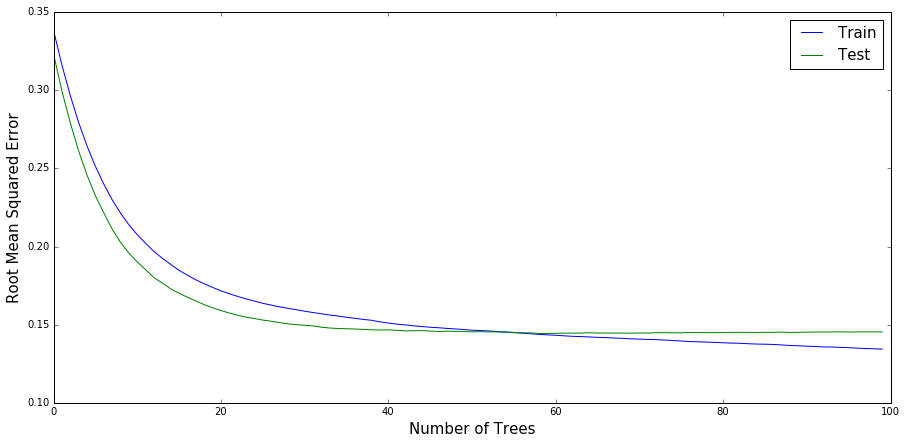

In [4]:
'''
Set default hyperparameter values, then monitor model performance (rmse) as trees are added.
'''

defaults = {'objective': 'reg:linear', 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 
            'subsample': 1, 'colsample_bytree': 1.0, 'colsample_bylevel': 1, 
            'reg_alpha': 0, 'reg_lambda': 1.0, 
            'seed': 0, 'nthread': -1, 'silent': True}

target = targets[8]

# Fit model to training data
xgb1     = XGBRegressor(**defaults)
eval_set = [(df0_train[predictors], df0_train[target]), 
            (df0_test[predictors], df0_test[target])]
%time xgb1.fit(df0_train[predictors], df0_train[target], eval_metric=["rmse"], eval_set=eval_set, verbose=False)

# Make predictions for test data
df0_test_predictions = xgb1.predict(df0_test[predictors])

# Retrieve performance metrics
results             = xgb1.evals_result()
min_index, min_rmse = min(enumerate(results['validation_1']['rmse']), key=itemgetter(1))
n_trees_best        = min_index + 1
rmse_test           = np.sqrt(mean_squared_error(df0_test[target].values, df0_test_predictions))
n_trees_final       = len(results['validation_1']['rmse'])
print('Algorithm: {0}'.format(xgb1))
print("RMSE on Test Set at Best Iteration:  {0}, Number of Trees: {1}".format(min_rmse, n_trees_best))
print("RMSE on Test Set at Final Iteration: {0}, Number of Trees: {1}".format(rmse_test, n_trees_final))

#  Plot learning curves
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.plot(x_axis, results['validation_0']['rmse'], label='Train')
axis.plot(x_axis, results['validation_1']['rmse'], label='Test')
axis.legend(fontsize=15)
axis.set_xlabel('Number of Trees', fontsize=15)
axis.set_ylabel('Root Mean Squared Error', fontsize=15)
plt.show()

<a id='Cell5'></a>

CPU times: user 3.01 s, sys: 125 ms, total: 3.13 s
Wall time: 52 s

Best score: 0.0274430517187, using {'n_estimators': 80, 'max_depth': 3}

0.0282390262413 +/- 0.00440439328908, with {'n_estimators': 40, 'max_depth': 3}
0.0278448969288 +/- 0.00440650471654, with {'n_estimators': 50, 'max_depth': 3}
0.0276720346827 +/- 0.00427347220149, with {'n_estimators': 60, 'max_depth': 3}
0.0276518368736 +/- 0.0041913115238, with {'n_estimators': 70, 'max_depth': 3}
0.0274430517187 +/- 0.00417020409422, with {'n_estimators': 80, 'max_depth': 3}
0.0274698304374 +/- 0.00411670619414, with {'n_estimators': 90, 'max_depth': 3}
0.0276823910146 +/- 0.00405190866018, with {'n_estimators': 100, 'max_depth': 3}
0.0278310625782 +/- 0.00408790267275, with {'n_estimators': 110, 'max_depth': 3}
0.0279985731844 +/- 0.00463293623954, with {'n_estimators': 40, 'max_depth': 5}
0.0278712257801 +/- 0.0045076486399, with {'n_estimators': 50, 'max_depth': 5}
0.0278600775375 +/- 0.00454063825968, with {'n_estimators':

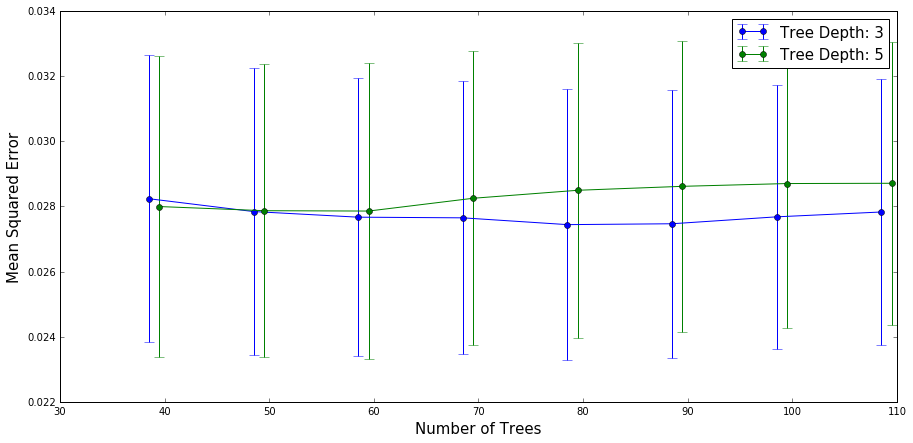

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1, 'learning_rate': 0.1, 'n_estimators': 80, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 1, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 3}


In [5]:
'''
Tune the number and size of trees using cross-validation.
'''

# Grid search
xgb1       = XGBRegressor(**defaults)
searchGrid = {'n_estimators': [40, 50, 60, 70, 80, 90, 100, 110], 'max_depth': [3, 5]}
tscv       = TimeSeriesSplit(n_splits=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, refit=True)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(-mean, stdev, param))
        
# Plot results (flip the score signs so we have mse instead of -mse).
n_xval    = len(searchGrid['n_estimators'])
n_yval    = len(searchGrid['max_depth'])
scores    = -np.array(means).reshape(n_yval, n_xval)
escores   = np.array(stds).reshape(n_yval, n_xval)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
x_offset = [-1.5, -0.5, 0.5, 1.5]
for i, value in enumerate(searchGrid['max_depth']):
    plt.errorbar(x_offset[i]+np.array(searchGrid['n_estimators']), scores[i], 
                 yerr=escores[i], fmt='-o', capsize=5, label='Tree Depth: '+str(value))
plt.legend(fontsize=15)
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell6'></a>

CPU times: user 4.27 s, sys: 180 ms, total: 4.45 s
Wall time: 1min 41s

Best score: 0.0274430517187, using {'n_estimators': 80, 'learning_rate': 0.1}

0.0822973266571 +/- 0.0135900009916, with {'n_estimators': 40, 'learning_rate': 0.01}
0.0742467326771 +/- 0.0130425601448, with {'n_estimators': 50, 'learning_rate': 0.01}
0.0674382186752 +/- 0.0124336925179, with {'n_estimators': 60, 'learning_rate': 0.01}
0.0616619165842 +/- 0.0117548063012, with {'n_estimators': 70, 'learning_rate': 0.01}
0.056788360444 +/- 0.0110776272004, with {'n_estimators': 80, 'learning_rate': 0.01}
0.0527254686153 +/- 0.0104775839793, with {'n_estimators': 90, 'learning_rate': 0.01}
0.0493495158856 +/- 0.00982573030763, with {'n_estimators': 100, 'learning_rate': 0.01}
0.0464392079434 +/- 0.00911661007938, with {'n_estimators': 110, 'learning_rate': 0.01}
0.0439394269891 +/- 0.00848329540075, with {'n_estimators': 120, 'learning_rate': 0.01}
0.041753495781 +/- 0.00789704246065, with {'n_estimators': 130, 'learn

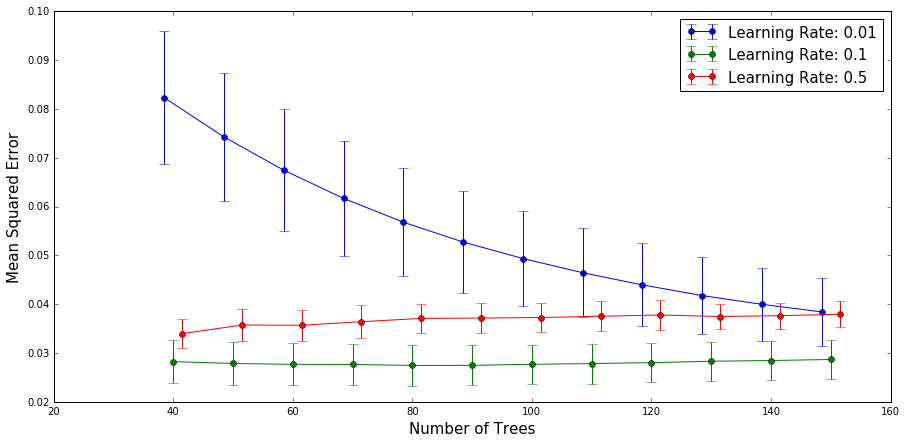

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1, 'learning_rate': 0.1, 'n_estimators': 80, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 1, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 3}


In [6]:
'''
Tune the learning rate and the number of trees using cross-validation.
Learning rate: step size shrinkage used in update to prevent overfitting. 
After each boosting step, we can directly get the weights of new features, 
and the learning rate shrinks the feature weights to make the boosting process more conservative.
Range is [0,1].
'''

# Grid search
xgb1       = XGBRegressor(**defaults)
searchGrid = {'n_estimators': [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], 'learning_rate': [0.01, 0.1, 0.5]}
tscv       = TimeSeriesSplit(n_splits=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, refit=True)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(-mean, stdev, param))
        
# Plot results (flip the score signs so we have mse instead of -mse).
n_xval    = len(searchGrid['n_estimators'])
n_yval    = len(searchGrid['learning_rate'])
scores    = -np.array(means).reshape(n_yval, n_xval)
escores   = np.array(stds).reshape(n_yval, n_xval)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
x_offset  = [-1.5, 0.0, 1.5]
for i, value in enumerate(searchGrid['learning_rate']):
    plt.errorbar(x_offset[i]+np.array(searchGrid['n_estimators']), scores[i], 
                 yerr=escores[i], fmt='-o', capsize=5, label='Learning Rate: '+str(value))
plt.legend(fontsize=15)
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell7'></a>

CPU times: user 2 s, sys: 86.2 ms, total: 2.09 s
Wall time: 17.9 s

Best score: 0.0268485195925, using {'subsample': 0.4}

0.0284104612645 +/- 0.00427882967794, with {'subsample': 0.1}
0.0283995323575 +/- 0.00474511819946, with {'subsample': 0.2}
0.0273583567225 +/- 0.00451644517599, with {'subsample': 0.3}
0.0268485195925 +/- 0.00468757655073, with {'subsample': 0.4}
0.0271200778132 +/- 0.00449760054303, with {'subsample': 0.5}
0.0272880125391 +/- 0.00471296553059, with {'subsample': 0.6}
0.027300491512 +/- 0.00446219268679, with {'subsample': 0.7}
0.0276015390548 +/- 0.00431555501298, with {'subsample': 0.8}
0.0271508313962 +/- 0.0044767682573, with {'subsample': 0.9}
0.0274430517187 +/- 0.00417020409422, with {'subsample': 1.0}


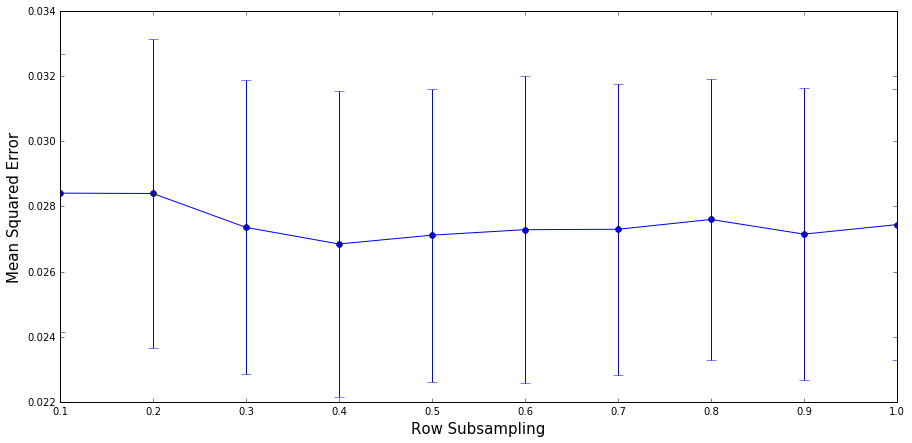

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1, 'learning_rate': 0.1, 'n_estimators': 80, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.4, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 3}


In [7]:
'''
Tune the row subsampling: subsample ratio of the training instances. 
Setting it to 0.5 means that XGBoost will randomly sample half of the training data prior to growing trees,
and this will prevent overfitting. Subsampling occurs once in every boosting iteration. Range is [0,1].
'''

# Grid search
xgb1       = XGBRegressor(**defaults)
searchGrid = {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
tscv       = TimeSeriesSplit(n_splits=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, refit=True)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plt.errorbar(searchGrid['subsample'], means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Row Subsampling', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell8'></a>

CPU times: user 1.73 s, sys: 75.7 ms, total: 1.8 s
Wall time: 9.04 s

Best score: 0.0268485195925, using {'colsample_bylevel': 1.0}

0.0275161066006 +/- 0.00499580714878, with {'colsample_bylevel': 0.4}
0.0274535498609 +/- 0.00445102343629, with {'colsample_bylevel': 0.5}
0.0274044124033 +/- 0.00479681243697, with {'colsample_bylevel': 0.6}
0.0272771652544 +/- 0.00395695361309, with {'colsample_bylevel': 0.7}
0.0281463049622 +/- 0.00420521845243, with {'colsample_bylevel': 0.8}
0.0278259413684 +/- 0.00464203379659, with {'colsample_bylevel': 0.9}
0.0268485195925 +/- 0.00468757655073, with {'colsample_bylevel': 1.0}


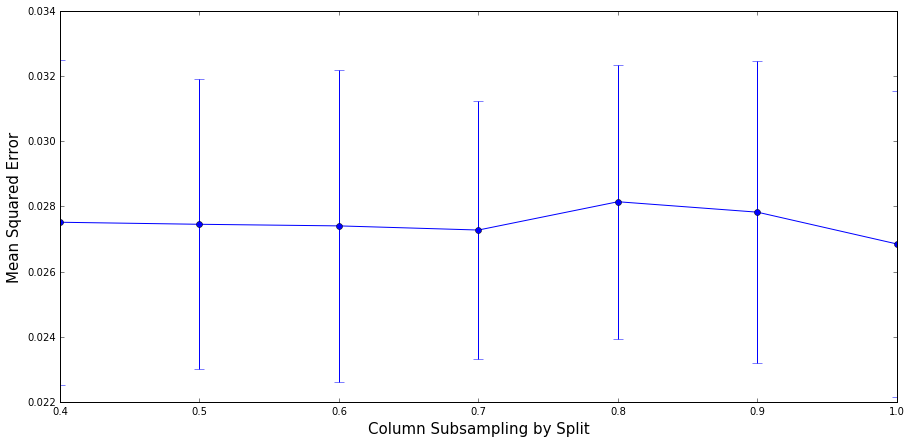

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1.0, 'learning_rate': 0.1, 'n_estimators': 80, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.4, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 3}


In [8]:
'''
Tune the column subsampling by split: the subsample ratio of columns for each split, in each level. 
Subsampling will occur each time a new split is made. Range is [0,1].
'''

# Grid search
xgb1       = XGBRegressor(**defaults)
searchGrid = {'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
tscv       = TimeSeriesSplit(n_splits=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, refit=True)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plt.errorbar(searchGrid['colsample_bylevel'], means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Column Subsampling by Split', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell9'></a>

CPU times: user 1.73 s, sys: 79.3 ms, total: 1.81 s
Wall time: 9.09 s

Best score: 0.0265571958764, using {'colsample_bytree': 0.9}

0.0271976524827 +/- 0.00430847189982, with {'colsample_bytree': 0.4}
0.0272396364151 +/- 0.0040731502096, with {'colsample_bytree': 0.5}
0.0273347250027 +/- 0.00390349665538, with {'colsample_bytree': 0.6}
0.0272262142279 +/- 0.00416563408121, with {'colsample_bytree': 0.7}
0.0274687991399 +/- 0.0039489497962, with {'colsample_bytree': 0.8}
0.0265571958764 +/- 0.00432546185504, with {'colsample_bytree': 0.9}
0.0268485195925 +/- 0.00468757655073, with {'colsample_bytree': 1.0}


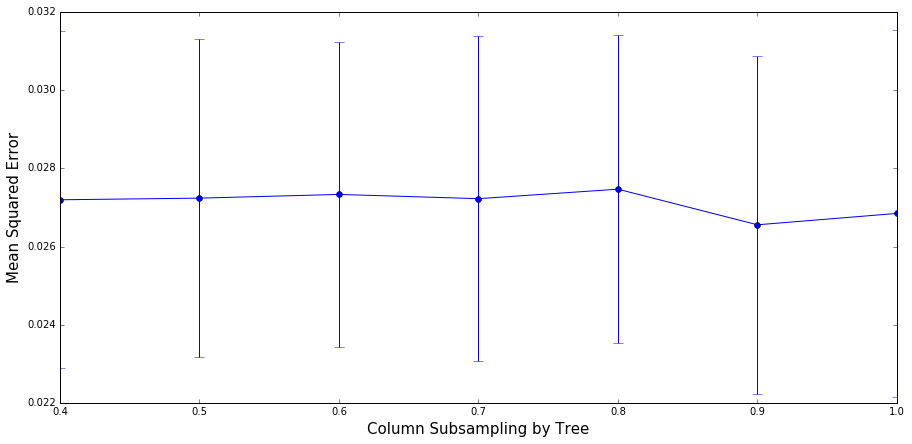

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1.0, 'learning_rate': 0.1, 'n_estimators': 80, 'seed': 0, 'colsample_bytree': 0.9, 'silent': True, 'nthread': -1, 'subsample': 0.4, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 3}


In [9]:
'''
Tune the column subsampling by tree: the subsample ratio of columns when constructing each tree. 
Subsampling occurs once in every boosting iteration. Range is [0.1].
'''

# Grid search
xgb1       = XGBRegressor(**defaults)
searchGrid = {'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
tscv       = TimeSeriesSplit(n_splits=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, refit=True)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plt.errorbar(searchGrid['colsample_bytree'], means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Column Subsampling by Tree', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell10'></a>

CPU times: user 1.77 s, sys: 77.8 ms, total: 1.84 s
Wall time: 11.6 s

Best score: 0.0265571064267, using {'reg_alpha': 0.0001}

0.026557187119 +/- 0.00432545973855, with {'reg_alpha': 1e-05}
0.0265571064267 +/- 0.00432545179227, with {'reg_alpha': 0.0001}
0.0267071203561 +/- 0.00432045250493, with {'reg_alpha': 0.001}
0.0268576378932 +/- 0.00422023227998, with {'reg_alpha': 0.01}
0.0265674388968 +/- 0.00430307774323, with {'reg_alpha': 0.1}
0.0266421577624 +/- 0.00460612851165, with {'reg_alpha': 1.0}
0.0287574581041 +/- 0.00455904188191, with {'reg_alpha': 10.0}
0.0562857278881 +/- 0.029292827993, with {'reg_alpha': 100.0}


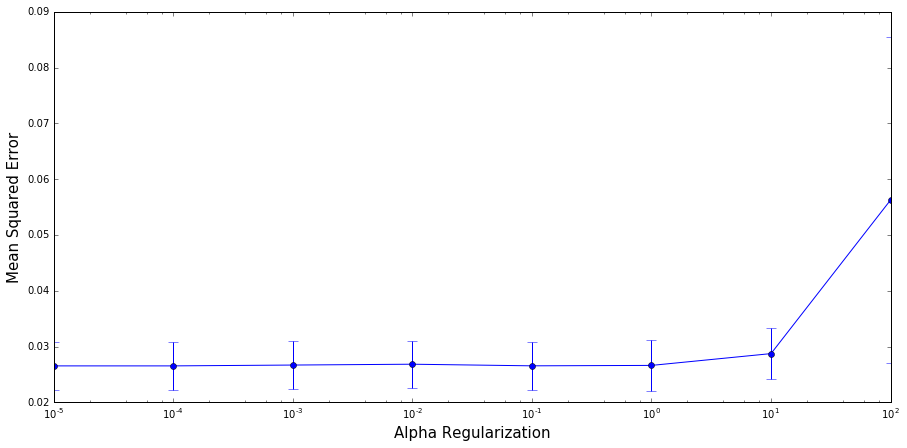

Updated settings: {'reg_alpha': 0.0001, 'colsample_bylevel': 1.0, 'learning_rate': 0.1, 'n_estimators': 80, 'seed': 0, 'colsample_bytree': 0.9, 'silent': True, 'nthread': -1, 'subsample': 0.4, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 3}


In [10]:
'''
Tune the alpha regularization parameter (L1 regularization term on weights. 
Increasing this value will make model more conservative).
'''

# Grid search
xgb1       = XGBRegressor(**defaults)
searchGrid = {'reg_alpha': [1.0E-05, 1.0E-04, 1.0E-03, 1.0E-02, 0.1, 1.0, 10.0, 100.0]}
tscv       = TimeSeriesSplit(n_splits=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, refit=True)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.errorbar(searchGrid['reg_alpha'], means, yerr=stds, fmt='-o', capsize=5)
axis.set_xlabel('Alpha Regularization', fontsize=15)
axis.set_xscale('log')
axis.set_ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell11'></a>

CPU times: user 1.55 s, sys: 66.6 ms, total: 1.62 s
Wall time: 8.68 s

Best score: 0.0265327434377, using {'reg_lambda': 10.0}

0.027373601178 +/- 0.00398701890232, with {'reg_lambda': 0.01}
0.0274847112577 +/- 0.004322027204, with {'reg_lambda': 0.1}
0.0265571064267 +/- 0.00432545179227, with {'reg_lambda': 1.0}
0.0265327434377 +/- 0.00458424664306, with {'reg_lambda': 10.0}
0.0266781643019 +/- 0.00399417950438, with {'reg_lambda': 100.0}


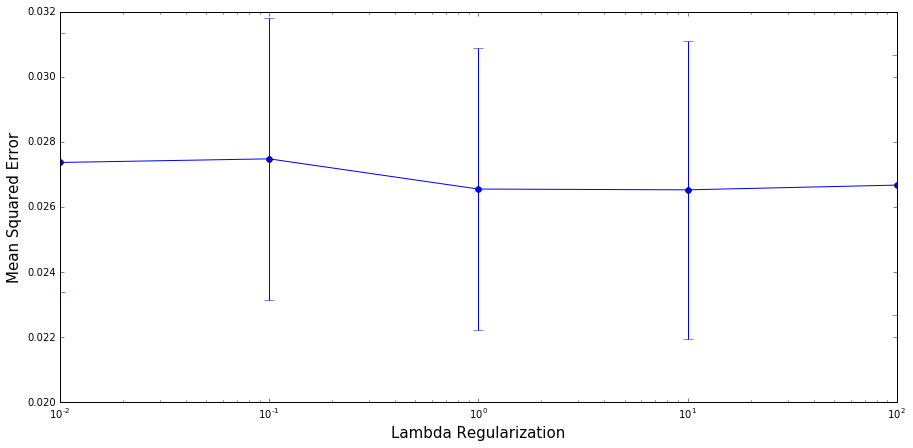

Updated settings: {'reg_alpha': 0.0001, 'colsample_bylevel': 1.0, 'learning_rate': 0.1, 'n_estimators': 80, 'seed': 0, 'colsample_bytree': 0.9, 'silent': True, 'nthread': -1, 'subsample': 0.4, 'reg_lambda': 10.0, 'objective': 'reg:linear', 'max_depth': 3}


In [11]:
'''
Tune the lambda regularization parameter (L2 regularization term on weights. 
Increasing this value will make model more conservative).
'''

# Grid search
xgb1       = XGBRegressor(**defaults)
searchGrid = {'reg_lambda': [0.01, 0.1, 1.0, 10.0, 100.0]}
tscv       = TimeSeriesSplit(n_splits=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, refit=True)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.errorbar(searchGrid['reg_lambda'], means, yerr=stds, fmt='-o', capsize=5)
axis.set_xlabel('Lambda Regularization', fontsize=15)
axis.set_xscale('log')
axis.set_ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell11a'></a>

CPU times: user 1.55 s, sys: 65.4 ms, total: 1.61 s
Wall time: 7.97 s

Best score: 0.0265327434377, using {'gamma': 0.0}

0.0265327434377 +/- 0.00458424664306, with {'gamma': 0.0}
0.0392336465113 +/- 0.0104128988036, with {'gamma': 5.0}
0.0524431671135 +/- 0.0189802796987, with {'gamma': 10.0}
0.0597197524054 +/- 0.0216133982387, with {'gamma': 15.0}
0.0660562976163 +/- 0.0243792955694, with {'gamma': 20.0}


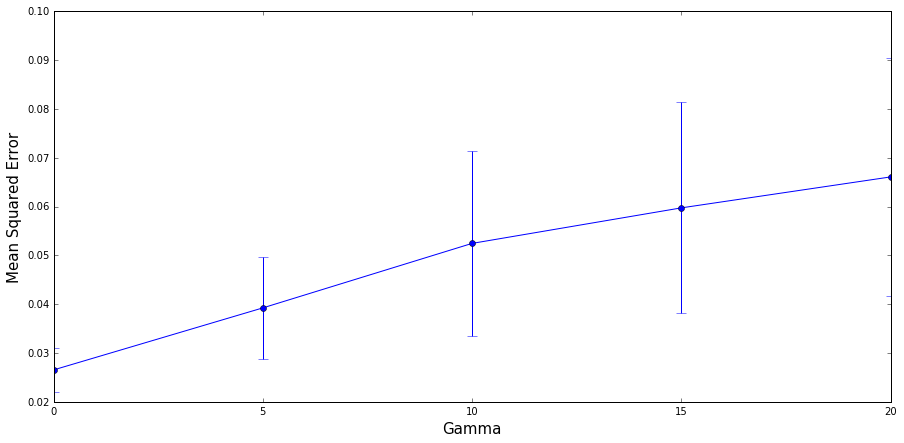

Updated settings: {'reg_alpha': 0.0001, 'colsample_bylevel': 1.0, 'learning_rate': 0.1, 'n_estimators': 80, 'seed': 0, 'colsample_bytree': 0.9, 'silent': True, 'nthread': -1, 'subsample': 0.4, 'reg_lambda': 10.0, 'objective': 'reg:linear', 'max_depth': 3, 'gamma': 0.0}


In [12]:
'''
Tune gamma, the minimum loss reduction required to make a further partition on a leaf node of a tree. 
The larger gamma is, the more conservative the algorithm will be.
'''

# Grid search
xgb1       = XGBRegressor(**defaults)
searchGrid = {'gamma': [0.0, 5.0, 10.0, 15.0, 20.0]}
tscv       = TimeSeriesSplit(n_splits=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, refit=True)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.errorbar(searchGrid['gamma'], means, yerr=stds, fmt='-o', capsize=5)
axis.set_xlabel('Gamma', fontsize=15)
axis.set_ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell11b'></a>

CPU times: user 1.68 s, sys: 71.5 ms, total: 1.75 s
Wall time: 10.6 s

Best score: 0.0262475379123, using {'min_child_weight': 10.0}

0.0265327434377 +/- 0.00458424664306, with {'min_child_weight': 0.0}
0.0265327434377 +/- 0.00458424664306, with {'min_child_weight': 1.0}
0.0262475379123 +/- 0.00474801027185, with {'min_child_weight': 10.0}
0.0267797714498 +/- 0.00482213423023, with {'min_child_weight': 20.0}
0.0267817229851 +/- 0.00501430132786, with {'min_child_weight': 30.0}
0.0266177079806 +/- 0.0049433558531, with {'min_child_weight': 40.0}
0.0265685285753 +/- 0.00506245908648, with {'min_child_weight': 50.0}


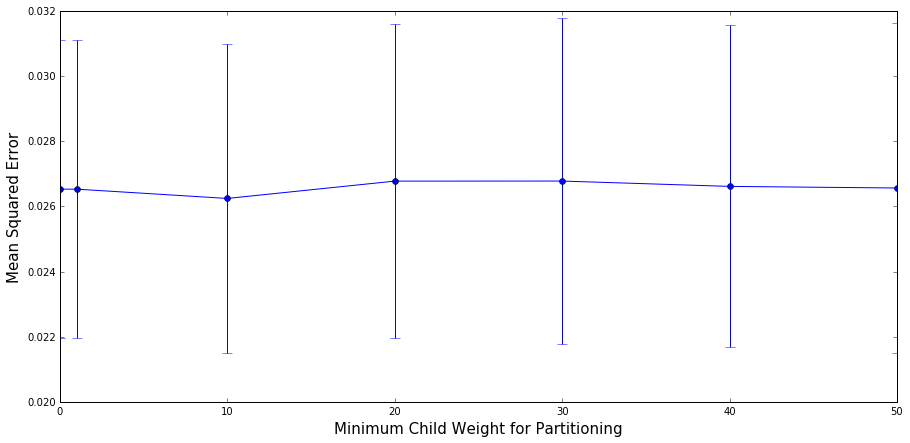

Updated settings: {'reg_alpha': 0.0001, 'colsample_bylevel': 1.0, 'learning_rate': 0.1, 'n_estimators': 80, 'seed': 0, 'colsample_bytree': 0.9, 'silent': True, 'nthread': -1, 'min_child_weight': 10.0, 'subsample': 0.4, 'reg_lambda': 10.0, 'objective': 'reg:linear', 'max_depth': 3, 'gamma': 0.0}


In [13]:
'''
Tune min_child_weight, the minimum sum of instance weight (hessian) needed in a child 
to continue partitioning. The larger min_child_weight, the more conservative the algorithm.
'''

# Grid search
xgb1       = XGBRegressor(**defaults)
searchGrid = {'min_child_weight': [0.0, 1.0, 10.0, 20.0, 30.0, 40.0, 50.0]}
tscv       = TimeSeriesSplit(n_splits=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, refit=True)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.errorbar(searchGrid['min_child_weight'], means, yerr=stds, fmt='-o', capsize=5)
axis.set_xlabel('Minimum Child Weight for Partitioning', fontsize=15)
axis.set_ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell12'></a>

## Fit model to training subset of training sample and check properties on test subset.

<a id='Cell12'></a>

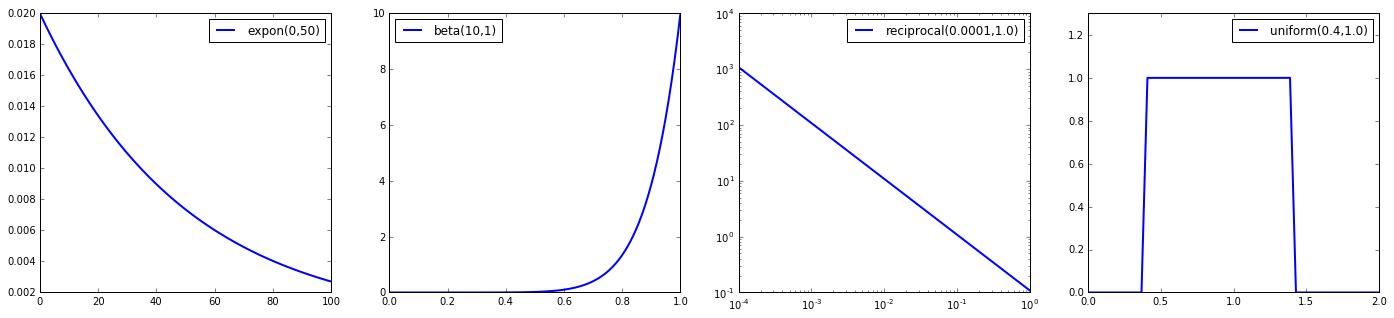

In [14]:
'''
Plot some scipy functions to prepare randomized optimization.
'''
rv1 = st.expon(0, 50)
rv2 = st.beta(10, 1)
rv3 = st.reciprocal(0.0001, 1.0)
rv4 = st.uniform(0.4, 1.0)
x1 = np.linspace(0.0, 100.0, 100)
x2 = np.linspace(0.0, 1.0, 100)
x3 = np.linspace(0.0001, 1.0, 100)
x4 = np.linspace(0.0, 2.0)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24,5))
ax[0].plot(x1, rv1.pdf(x1), 'b-', lw=2, label='expon(0,50)')
ax[0].legend(loc='upper right')
ax[1].plot(x2, rv2.pdf(x2), 'b-', lw=2, label='beta(10,1)')
ax[1].legend(loc='upper left')
ax[2].plot(x3, rv3.pdf(x3), 'b-', lw=2, label='reciprocal(0.0001,1.0)')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].legend(loc='upper right')
ax[3].plot(x4, rv4.pdf(x4), 'b-', lw=2, label='uniform(0.4,1.0)')
ax[3].set_ylim([0.0, 1.3])
ax[3].legend(loc='upper right')
plt.show()

In [15]:
%%time
'''
Create separate models for each of the ten turbines, using time-series cross-validation with randomized search.
'''
settings_space   = {"n_estimators": st.randint(3, 100),
                    "max_depth": st.randint(3, 10),
                    "learning_rate": st.reciprocal(0.01, 1.0),
                    "colsample_bytree": st.uniform(0.4, 0.6),
                    "colsample_bylevel": st.uniform(0.4, 0.6),
                    "subsample": st.uniform(0.1, 0.9),
                    "gamma": st.uniform(0, 10),
                    "reg_alpha": st.reciprocal(1.0E-5, 100),
                    "reg_lambda": st.reciprocal(1.0E-5, 100),
                    "min_child_weight": st.expon(0, 50)}

default_settings = {'objective': 'reg:linear', 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 
                    'subsample': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'gamma': 0,
                    'reg_alpha': 10, 'reg_lambda': 10.0, 'seed': 0, 'nthread': -1, 'silent': True}

n_iterations     = 200
tscv             = TimeSeriesSplit(n_splits=5)
xgb1             = XGBRegressor(**default_settings)
settings         = [default_settings.copy() for _ in xrange(nturbines)]
xgbr_train_all   = []
for target, setting in zip(targets, settings):
    print('\nFitting turbine {0}...'.format(target[10:]))
    xgbGrid = RandomizedSearchCV(estimator=xgb1, param_distributions=settings_space, 
                                 n_iter=n_iterations, scoring='neg_mean_squared_error',
                                 refit=True, cv=tscv, random_state=789)
    xgbGrid.fit(df0_train[predictors], df0_train[target])
    setting.update(xgbGrid.best_params_)
    print('Updated parameters: {0}\nBest score: {1}'.format(xgbGrid.best_params_, xgbGrid.best_score_))
    xgbr_train_all.append(xgbGrid.best_estimator_)
    
fName = 'xgbr_train_' + strftime("%Y_%m_%d_%H_%M_%S")
path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(xgbr_train_all, path_to_file)
print('\nExtreme gradient boosting regression model saved to {0}'.format(path_to_file))


Fitting turbine 1...
Updated parameters: {'reg_alpha': 0.018251542302808833, 'colsample_bytree': 0.95989023254275585, 'colsample_bylevel': 0.87031402563536564, 'learning_rate': 0.18297349496874821, 'min_child_weight': 13.081026005152276, 'n_estimators': 88, 'subsample': 0.72182468063666527, 'reg_lambda': 9.1885501128821483e-05, 'max_depth': 9, 'gamma': 0.48062955201420676}
Best score: -0.019592079296

Fitting turbine 2...
Updated parameters: {'reg_alpha': 0.0062522953262931823, 'colsample_bytree': 0.8952315376365072, 'colsample_bylevel': 0.53696957229872977, 'learning_rate': 0.25246445547828089, 'min_child_weight': 37.375174274310446, 'n_estimators': 38, 'subsample': 0.61191570337113688, 'reg_lambda': 96.319040618713316, 'max_depth': 7, 'gamma': 0.15411012849797512}
Best score: -0.0217516065051

Fitting turbine 3...
Updated parameters: {'reg_alpha': 0.0062522953262931823, 'colsample_bytree': 0.8952315376365072, 'colsample_bylevel': 0.53696957229872977, 'learning_rate': 0.2524644554782

With 100 iterations all turbines have the same set of parameter values:

Fitting turbine 1...
Updated parameters: {'reg_alpha': 0.0062522953262931823, 'colsample_bytree': 0.8952315376365072, 'colsample_bylevel': 0.53696957229872977, 'learning_rate': 0.25246445547828089, 'min_child_weight': 37.375174274310446, 'n_estimators': 38, 'subsample': 0.61191570337113688, 'reg_lambda': 96.319040618713316, 'max_depth': 7, 'gamma': 0.15411012849797512}
Best score: -0.0209557812351

In [20]:
'''
Only run this cell if you have an active xgbr_train_all 
and wish to change it by running the next cell.
'''
del(xgbr_train_all)

<a id='Cell13'></a>

In [21]:
'''
Retrieve from disk the regressor model that was trained on the training subsample only. 
'''

xgbr_found = True

try:
    xgbr_train_all
except:
#    fName = 'xgbr_train_2017_03_29_02_35_39' # rm=3, dups removed, (U,V,time) replaced by (H)
#    fName = 'xgbr_train_2017_03_28_04_50_26' # rm=3, dups removed
#    fName = 'xgbr_train_2017_10_23_03_15_30' # rm=3, dups removed, single obs retained
#    fName = 'xgbr_train_2017_03_10_21_31_44' # rm=3
#    fName = 'xgbr_train_2017_03_11_06_51_08' # rm=4
#    fName = 'xgbr_train_2017_03_12_04_27_43' # rm=2
#    fName = 'xgbr_train_2017_03_10_03_54_47'
    fName = 'xgbr_train_2017_03_08_10_53_03'
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        xgbr_train_all = joblib.load(path_to_file)
    except:
        print('Error loading regressor model from {0}\n'.format(path_to_file))
        xgbr_found = False
    else:
        print('Regressor model successfully loaded from {0}\n'.format(path_to_file))    
else:    
    print('Regressor model already exists, not updated from file!\n')

if xgbr_found:
    for ind, xgbr in enumerate(xgbr_train_all):
        print('Turbine {0}:\nRegressor: {1}\n'.format(ind+1, xgbr))

Regressor model successfully loaded from fitted_models/xgbr_train_2017_03_08_10_53_03.model

Turbine 1:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.6, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0.001, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

Turbine 2:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=1.0, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

Turbine 3:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=1.0, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weigh

<a id='Cell14'></a>

In [16]:
'''
Test the fitted models on the testing subset.
'''

Nturbines       = len(xgbr_train_all)
MSE_Train_Total = 0.0
MSE_Test_Total  = 0.0
for ind,xgb in enumerate(xgbr_train_all):
    
    target = 'TARGETVAR_'+str(ind+1)
    
    # Predict training set and testing set
    df0_train_predictions = xgb.predict(df0_train[predictors])
    df0_test_predictions  = xgb.predict(df0_test[predictors])
    df0_train_predictions = [min(max(x,0.0),1.0) for x in df0_train_predictions]
    df0_test_predictions  = [min(max(x,0.0),1.0) for x in df0_test_predictions]
    
    # Compute performance measures
    R2_Train  = r2_score(df0_train[target].values, df0_train_predictions)
    R2_Test   = r2_score(df0_test[target].values, df0_test_predictions)
    MSE_Train = mean_squared_error(df0_train[target].values, df0_train_predictions)
    MSE_Test  = mean_squared_error(df0_test[target].values, df0_test_predictions)

    # Compute confusion matrix for classifying zero turbine output
    cm = confusion_matrix([1 if v==0.0 else 0 for v in df0_test[target]], 
                          [1 if v==0.0 else 0 for v in df0_test_predictions])
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    
    # Print model report
    print('\nModel Report for Turbine {0}'.format(ind+1))
    print('On training set: R^2 =  {0}'.format(R2_Train))
    print('                 RMSE = {0}'.format(np.sqrt(MSE_Train)))
    print('On testing set:  R^2 =  {0}'.format(R2_Test))
    print('                 RMSE = {0}'.format(np.sqrt(MSE_Test)))
    print('                 Confusion Matrix: tp = {0}, fn = {1}, fp = {2}, tn = {3}'.format(tp, fn, fp, tn))
    print('                 Recall = {0}, Precision = {1}, Queue Rate = {2}'.\
          format(float(tp)/max(1,(tp+fn)), float(tp)/max(1,(tp+fp)), float(tp+fp)/(tp+fp+tn+fn)))
    MSE_Train_Total += MSE_Train
    MSE_Test_Total  += MSE_Test
print('\nTotal RMSE on training set: {0}'.format(np.sqrt(MSE_Train_Total/Nturbines)))
print('Total RMSE on testing set:  {0}'.format(np.sqrt(MSE_Test_Total/Nturbines)))


Model Report for Turbine 1
On training set: R^2 =  0.864863390668
                 RMSE = 0.103400036372
On testing set:  R^2 =  0.769423296603
                 RMSE = 0.128945668439
                 Confusion Matrix: tp = 0, fn = 442, fp = 0, tn = 3429
                 Recall = 0.0, Precision = 0.0, Queue Rate = 0.0

Model Report for Turbine 2
On training set: R^2 =  0.820469424571
                 RMSE = 0.107396393005
On testing set:  R^2 =  0.736961317378
                 RMSE = 0.143054987275
                 Confusion Matrix: tp = 0, fn = 128, fp = 0, tn = 3743
                 Recall = 0.0, Precision = 0.0, Queue Rate = 0.0

Model Report for Turbine 3
On training set: R^2 =  0.83750913452
                 RMSE = 0.121806078786
On testing set:  R^2 =  0.76109903749
                 RMSE = 0.138990403482
                 Confusion Matrix: tp = 24, fn = 213, fp = 15, tn = 3619
                 Recall = 0.101265822785, Precision = 0.615384615385, Queue Rate = 0.0100749160424

Model

<a id='Cell14b'></a>

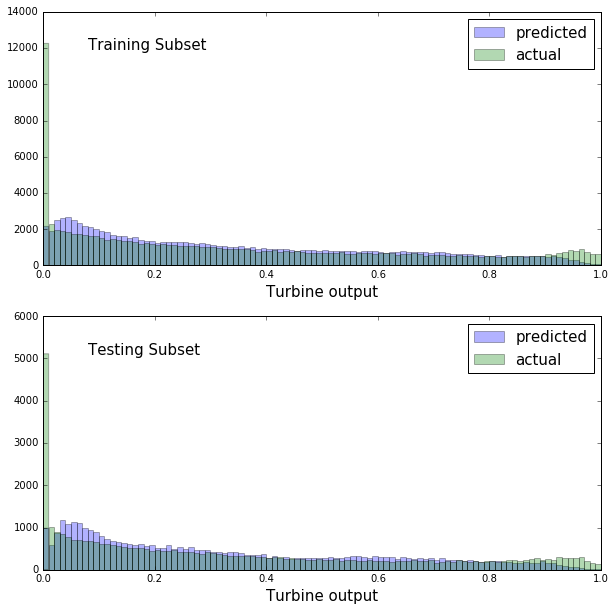

In [17]:
'''
Make histograms of the response variable in the training and testing subsets of the training data set.
'''

predicted_targets_train = []
actual_targets_train    = []
predicted_targets_test  = []
actual_targets_test     = []
for ind,xgb in enumerate(xgbr_train_all):
    target = 'TARGETVAR_'+str(ind+1)
    df0_train_predictions = xgb.predict(df0_train[predictors])
    df0_train_predictions = [min(max(x,0.0),1.0) for x in df0_train_predictions]
    predicted_targets_train.extend(df0_train_predictions)
    actual_targets_train.extend(df0_train[target].values)
    df0_test_predictions  = xgb.predict(df0_test[predictors])
    df0_test_predictions  = [min(max(x,0.0),1.0) for x in df0_test_predictions]
    predicted_targets_test.extend(df0_test_predictions)
    actual_targets_test.extend(df0_test[target].values)

fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(10,10) )
axis[0].hist(predicted_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='predicted')
axis[0].hist(actual_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='actual')
axis[0].set_xlabel("Turbine output", fontsize=15)
axis[0].legend(prop={'size': 15},loc="upper right")
axis[0].text(0.08, 0.85, "Training Subset", fontsize=15, transform=axis[0].transAxes)

axis[1].hist(predicted_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='predicted')
axis[1].hist(actual_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='actual')
axis[1].set_xlabel("Turbine output", fontsize=15)
axis[1].legend(prop={'size': 15},loc="upper right")
axis[1].text(0.08, 0.85, "Testing Subset", fontsize=15, transform=axis[1].transAxes)

plt.show()
fig.savefig('wind_turbine_output_train_test_xgb.png', dpi=200, bbox_inches='tight')

<a id='Cell14c'></a>

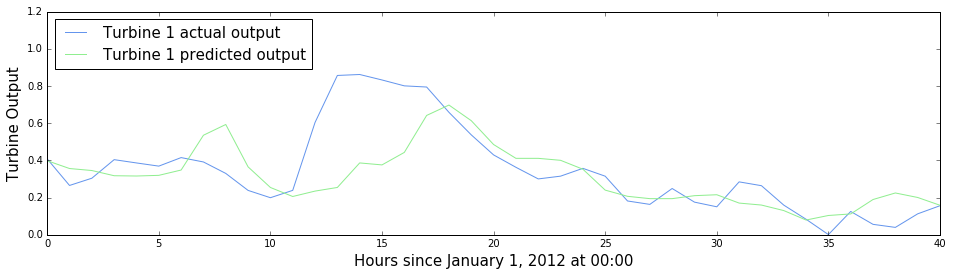

In [18]:
'''
Plot predicted and actual turbine power as a function of time.
'''
turbine = 1
npts    = 41

npts_pt = len(predicted_targets_test)/nturbines
npts_a  = min(npts, npts_pt)
ifirst  = npts_pt*(turbine-1)
ilast   = ifirst + npts_a
xval    = range(0, npts_a)
yval    = actual_targets_test[ifirst:ilast]
zval    = predicted_targets_test[ifirst:ilast]

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(16,4))

axis.plot(xval, yval, color="cornflowerblue", alpha=1.0, label="Turbine "+str(turbine)+" actual output")
axis.plot(xval, zval, color="lightgreen", alpha=1.0, label="Turbine "+str(turbine)+" predicted output")
axis.set_xlim([0., npts_a-1])
axis.set_ylim([0., 1.2])
axis.set_xlabel("Hours since January 1, 2012 at 00:00", fontsize=15)
axis.set_ylabel("Turbine Output", fontsize=15)
axis.legend(prop={'size': 15},loc="upper left")

plt.show()
fig.savefig('pred_actual_vs_time_1.png', dpi=200, bbox_inches='tight')

<a id='Cell15'></a>

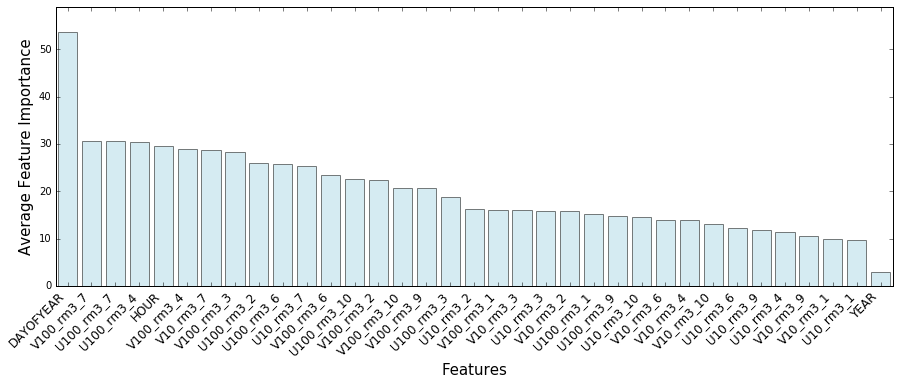

In [19]:
'''
Plot feature importances averaged over all turbines.
'''

all_feat_imp = []
for xgb in xgbr_train_all:
    all_feat_imp.append(xgb.booster().get_score(importance_type='weight'))
all_feat_imp_df = pd.DataFrame(all_feat_imp)
feat_imp        = all_feat_imp_df.mean().sort_values(ascending=False)
n_features      = min(50,len(feat_imp))
bins            = np.arange(n_features)
x_labels        = feat_imp.index.values[:n_features]
y_values        = feat_imp.values[:n_features]
maxHeight       = 1.10*max(y_values)

fig, axes  = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
axes.bar(bins, y_values, align="center", color="lightblue", edgecolor='k', alpha=0.5)
axes.set_xticks(bins)
axes.set_xticklabels(x_labels, ha="right", rotation=45., fontsize=12)
axes.set_xlim([-0.5,bins.size-0.5])
if len(feat_imp) <= 50:
    axes.set_xlabel('Features'.format(n_features), fontsize=15)
else:
    axes.set_xlabel('Top {0} Features'.format(n_features), fontsize=15)
axes.set_ylim([0.0, maxHeight])
axes.set_ylabel('Average Feature Importance', fontsize=15)
plt.show()
fig.savefig('XGBoost35_FeatureImportances.png', dpi=200, bbox_inches='tight')

## Refit model to entire training data set and create solution file.

<a id='Cell16'></a>

In [20]:
%%time
'''
Refit model with final settings to entire training data set and save fitted model to disk.
'''

xgbr_all = []
for target, setting in zip(targets, settings):
    xgb2 = XGBRegressor(**setting)
    xgb2.fit(df0[predictors], df0[target], eval_metric=["rmse"], verbose=False)
    xgbr_all.append(xgb2)
    
fName = 'xgbr_' + strftime("%Y_%m_%d_%H_%M_%S")
path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(xgbr_all, path_to_file)
print('\nExtreme gradient boosting regression model saved to {0}'.format(path_to_file))


Extreme gradient boosting regression model saved to fitted_models/xgbr_2018_10_21_21_44_19.model
CPU times: user 27.7 s, sys: 81.3 ms, total: 27.8 s
Wall time: 27.8 s


<a id='Cell17'></a>

In [12]:
'''
Retrieve trained model from disk. Only run this cell if previous one wasn't run.
Note that by default the file name encodes a date and time, to the second.
'''

xgbr_found = True

try:
    xgbr_all
except:
#    fName = 'xgb_2017_03_05_17_57_26' # No rolling average
#    fName = 'xgbr_2017_03_12_10_24_46' # rm=2
#    fName = 'xgbr_2017_03_10_22_09_58' # rm=3
#    fName = 'xgbr_2017_03_11_07_25_35' # rm=4
#    fName = 'xgbr_2017_03_28_07_24_58' # rm=3, dups removed
    fName = 'xgbr_2017_10_23_04_01_19' # rm=3, dups removed, single obs retained
#    fName = 'xgbr_2017_03_29_05_13_48' # rm=3, dups removed, (U,V,time) replaced by (H)
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        xgbr_all = joblib.load(path_to_file)
    except:
        print('Error loading regression model from {0}\n'.format(path_to_file))
        xgbr_found = False
    else:
        print('Regression model successfully loaded from {0}\n'.format(path_to_file))    
else:    
    print('Fitted model already exists, not updated from file!\n')

if xgbr_found:
    for ind, xgbr in enumerate(xgbr_all):
        print('Turbine {0}:\nRegressor: {1}\n'.format(ind+1, xgbr))

Regression model successfully loaded from fitted_models/xgbr_2017_03_28_07_24_58.model

Turbine 1:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

Turbine 2:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

Turbine 3:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.6, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, mi

<a id='Cell18'></a>

In [21]:
'''
Prepare the test data set in the same way as the training set, make predictions, and create output csv file.
'''

# Load the testing data
#TestingDataFile = "data/Test_pp_2017_03_02_15_47_36.pkl" # Without rolling average
#TestingDataFile = "data/Test_pp_2017_03_12_10_32_09.pkl" # rm=2
#TestingDataFile = "data/Test_pp_2017_03_10_15_38_00.pkl" # rm=3
#TestingDataFile = "data/Test_pp_2017_03_11_02_07_04.pkl" # rm=4
TestingDataFile = "data/Test_pp_2017_03_28_09_02_52.pkl" # rm=3, dups removed
#TestingDataFile = "data/Test_pp_2017_10_22_17_24_03.pkl" # rm=3, dups removed, single obs retained
df1             = pd.read_pickle(TestingDataFile)

# Rename dataframe columns and make lists with the new predictor labels
predictors  = [item[0]+'_'+str(item[1]) for item in df1.columns.values if item[0]!='ID']
predictors  = [predictor if predictor[-1]!='_' else predictor[:-1] for predictor in predictors]
ids         = [item[0]+'_'+str(item[1]) for item in df1.columns.values if item[0]=='ID']
df1.columns = ids+predictors

# Count how many sets of observations we have in August and September 2013
nTotal      = len(df1)
nAugSep2013 = len([DoY for DoY in df1['DAYOFYEAR'] if DoY>212 and DoY<274])
print('\nTotal number of observation times in test set:            {0}'.format(nTotal))
print('Number of observation times in August and September 2013: {0}'.format(nAugSep2013))

# If needed, transform predictor variables to be the same as in the gamlss analysis
if gamlss:
    for i in range(0,len(wind_measurements)):
        df1[H10label[i]]  = np.sqrt(df1[U10label[i]]**2 + df1[V10label[i]]**2)
        df1[H100label[i]] = np.sqrt(df1[U100label[i]]**2 + df1[V100label[i]]**2)
    df1.drop(U10label,  1, inplace=True)
    df1.drop(U100label, 1, inplace=True)
    df1.drop(V10label,  1, inplace=True)
    df1.drop(V100label, 1, inplace=True)
    df1.drop(["YEAR", "DAYOFYEAR", "HOUR"], 1, inplace=True)
    predictors = [item for item in df1.columns.values if item[:2]!='ID']

print('\nPredictor variables: {0}'.format(predictors))

# Compute predictions
df1_ids         = []
df1_predictions = []
for ind,xgb in enumerate(xgbr_all):
    obs_id = 'ID_'+str(ind+1)
    df1_ids.extend(df1[obs_id].tolist())
    df1_predictions.extend([min(max(x,0.0),1.0) for x in xgb.predict(df1[predictors])])

# Generate output csv file
fName_out = 'data/xgbr_' + strftime("%Y_%m_%d_%H_%M_%S") + '.out.csv'
with open(fName_out, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["ID","TARGETVAR"])
    for idval,yval in zip(df1_ids, df1_predictions):
        writer.writerow([idval,yval])
print('\nOutput written to {0}'.format(fName_out))


Total number of observation times in test set:            2929
Number of observation times in August and September 2013: 1464

Predictor variables: ['U10_rm3_1', 'U100_rm3_1', 'V10_rm3_1', 'V100_rm3_1', 'U10_rm3_2', 'U100_rm3_2', 'V10_rm3_2', 'V100_rm3_2', 'U10_rm3_3', 'U100_rm3_3', 'V10_rm3_3', 'V100_rm3_3', 'U10_rm3_4', 'U100_rm3_4', 'V10_rm3_4', 'V100_rm3_4', 'U10_rm3_6', 'U100_rm3_6', 'V10_rm3_6', 'V100_rm3_6', 'U10_rm3_7', 'U100_rm3_7', 'V10_rm3_7', 'V100_rm3_7', 'U10_rm3_9', 'U100_rm3_9', 'V10_rm3_9', 'V100_rm3_9', 'U10_rm3_10', 'U100_rm3_10', 'V10_rm3_10', 'V100_rm3_10', 'YEAR', 'DAYOFYEAR', 'HOUR']

Output written to data/xgbr_2018_10_21_21_44_54.out.csv


<a id='Cell19'></a>

Shape of solution data frame: (2929, 45)

Shape of final, combined training+solution data frame: (16800, 56)

Number of rmse data points: 100


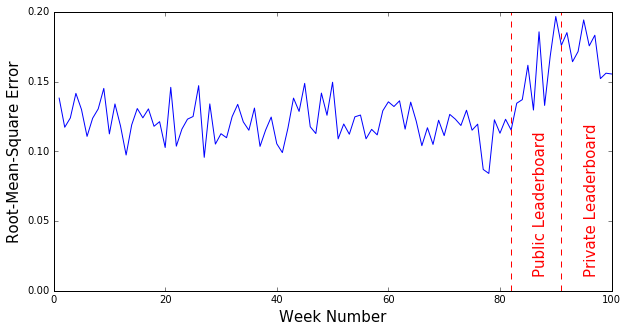

In [22]:
'''
Compute weekly RMSE, save to file and make a plot.
Assume we ran the first two cells of this notebook, so that df0 already contains the training data.
'''

# Select appropriate solution data file.
if rmws==1:
    rm = "_rm1_"
#    SolutionDataFile = "data/Solution_pp_2018_10_21_00_29_15.pkl" # Rmws=1, dups removed
    SolutionDataFile = "data/Solution_pp_2018_10_21_00_41_10.pkl" # Rmws=1, dups not removed
elif rmws==3:
    rm = "_rm3_"
    SolutionDataFile = "data/Solution_pp_2017_04_23_15_00_18.pkl" # Rolling means over 3 measurements, dups removed
#    SolutionDataFile = "data/Solution_pp_2017_10_22_17_25_26.pkl" # rm = 3, dups removed, single obs retained
else:
    print("Solution file with rolling mean over {0} measurement(s) not found.".format(rmws))
    
# Load solution data
df2 = pd.read_pickle(SolutionDataFile)
print('Shape of solution data frame: {0}'.format(df2.shape))

# Rename solution data frame columns to match training data frame.
df2.columns = targets+predictors

# Concatenate the training and solution data frames.
df3 = pd.concat([df0, df2])

# Create timestamp column and use it as index
def ydh_to_dt(row):
    year      = int(row['YEAR'])
    dayofyear = int(row['DAYOFYEAR'])
    hour      = int(row['HOUR'])
    return datetime.datetime(year, 1, 1, hour) + datetime.timedelta(dayofyear - 1)

df3['TIMESTAMP'] = df3.apply(ydh_to_dt, axis=1)
df3.set_index('TIMESTAMP', drop=True, append=False, inplace=True, verify_integrity=True)

# Make predictions
for ind,xgb in enumerate(xgbr_all):
    predicted_target = "PREDICT_"+str(ind+1)
    df3[predicted_target] = [min(max(x,0.0),1.0) for x in xgb.predict(df3[predictors])]

# Compute Mean Squared Error on the ten target variables in each row.
df3['MSE'] = sum([(df3['TARGETVAR_'+str(ind)]-df3['PREDICT_'+str(ind)])**2 for ind in range(1,11)])/10.0

print('\nShape of final, combined training+solution data frame: {0}'.format(df3.shape))

# Compute weekly rmse.
datetime0 = df3.index[0]
rmse      = np.sqrt(df3.groupby((df3.index-datetime0).days/7).MSE.mean())
npts      = len(rmse)
print('\nNumber of rmse data points: {0}'.format(npts))

# Save weekly rmse to file
with open('data/xgbr_weekly_rmse.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(rmse)
    
# Make plot
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
axis.plot(range(1,101), rmse )
axis.set_ylim([0.0, 0.20])
axis.set_xlabel("Week Number", fontsize=15)
axis.set_ylabel("Root-Mean-Square Error", fontsize=15)
axis.axvline(x=82, color="red", linestyle="dashed")
axis.axvline(x=91, color="red", linestyle="dashed")
axis.text(86, 0.01, "Public Leaderboard", rotation=90, verticalalignment="bottom", fontsize=15, color="red")
axis.text(95, 0.01, "Private Leaderboard", rotation=90, verticalalignment="bottom", fontsize=15, color="red")
plt.show()
fig.savefig('xgbr_weekly_rmse.png', dpi=200, bbox_inches='tight')